# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u


### read data:


Red arm:

In [2]:
hdu = fits.open('data/supercube_2963269.fit')

In [3]:
hdu.info()
wcs = WCS(hdu[1].header)
wavelength = wcs.spectral.pixel_to_world(np.arange(hdu[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function = hdu[5].data

Filename: data/supercube_2963269.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     472   ()      
  1  RED_DATA      1 ImageHDU        72   (174, 181, 9101)   float32   
  2  RED_IVAR      1 ImageHDU        72   (174, 181, 9101)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (174, 181, 9101)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (174, 181, 9101)   float32   
  5  RED_SENSFUNC    1 ImageHDU        15   (9101,)   float32   
  6  RED_DATA_COLLAPSE3    1 ImageHDU        72   (174, 181)   float32   
  7  RED_IVAR_COLLAPSE3    1 ImageHDU        72   (174, 181)   float32   


In [4]:
datacube = hdu[1].data * sensitivity_function[:, np.newaxis, np.newaxis]


In [5]:
lines = {}
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

wavelength_bins = np.array(lines['H_alpha'])
indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


In [6]:
Ha_map = np.nanmean(datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :], axis=0)
blue_side = np.nanmean(datacube[indices_Ha_b[3]:indices_Ha_b[4], :, :], axis=0)
red_side = np.nanmean(datacube[indices_Ha_a[5]:indices_Ha_a[6], :, :], axis=0)
continuum = (red_side+blue_side)/2
Ha_map = (Ha_map - continuum) * (wavelength[indices_Ha_a[2]] - wavelength[indices_Ha_b[1]])
noise = 1e-17
SNR_map = np.nanmean((datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :] - continuum)**2/noise, axis=0) / np.nanmean((datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :] - continuum), axis=0)

/tmp/ipykernel_7709/940874294.py:7: RuntimeWarning: invalid value encountered in true_divide
  SNR_map = np.nanmean((datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :] - continuum)**2/noise, axis=0) / np.nanmean((datacube[indices_Ha_b[1]:indices_Ha_a[2], :, :] - continuum), axis=0)


In [7]:
roi = [120, 140, 110, 130]

/tmp/ipykernel_7709/1445079094.py:24: RuntimeWarning: invalid value encountered in true_divide
  im = ax.imshow(Ha_map/continuum,


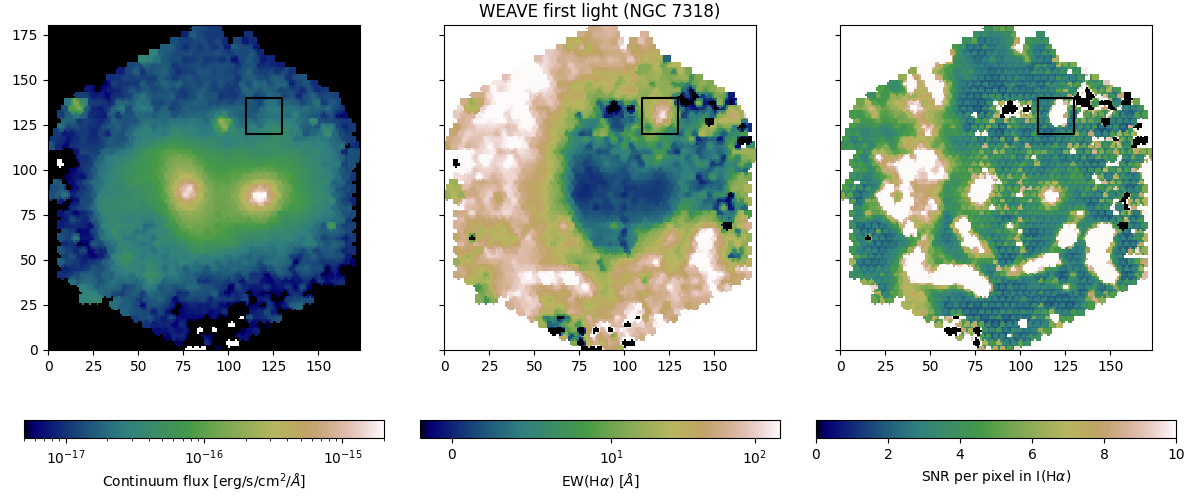

In [8]:
plt.close('H_alpha map')
fig = plt.figure('H_alpha map', figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'bottom': .02, 'left': .02, 'top': .95, 'right': .98, 'hspace': 0, 'wspace': .1}
                   )

ax = axes[0, 0]
im = ax.imshow(continuum,
               interpolation='nearest', origin='lower',
               #cmap='terrain',
               cmap='gist_earth',
               #cmap='inferno',
               #cmap='nipy_spectral_r',
               #vmin=-1e-15, vmax=5.5e-15,
               norm=colors.LogNorm(vmin=5e-18, vmax=2e-15),
              )
ax.plot([roi[2], roi[3], roi[3], roi[2], roi[2]], [roi[0], roi[0], roi[1], roi[1], roi[0]], 'k-')
cb = fig.colorbar(im, ax=ax, orientation='horizontal')
cb.ax.set_xlabel(r'Continuum flux [erg/s/cm$^2/\AA$]')

ax = axes[0, 1]
ax.set_title('WEAVE first light (NGC 7318)')
im = ax.imshow(Ha_map/continuum,
               interpolation='nearest', origin='lower',
               cmap='gist_earth',
               #vmin=-3, vmax=35,
               norm=colors.SymLogNorm(vmin=-2, vmax=150, linthresh=10),
              )
ax.plot([roi[2], roi[3], roi[3], roi[2], roi[2]], [roi[0], roi[0], roi[1], roi[1], roi[0]], 'k-')
cb = fig.colorbar(im, ax=ax, orientation='horizontal')
cb.ax.set_xlabel(r'EW(H$\alpha$) [$\AA$]')

ax = axes[0, 2]
im = ax.imshow(SNR_map,
               interpolation='nearest', origin='lower',
               cmap='gist_earth',
               vmin=0, vmax=10,
              )
ax.plot([roi[2], roi[3], roi[3], roi[2], roi[2]], [roi[0], roi[0], roi[1], roi[1], roi[0]], 'k-')
cb = fig.colorbar(im, ax=ax, orientation='horizontal')
cb.ax.set_xlabel(r'SNR per pixel in I(H$\alpha$)')

#show_data(Ha_map, ax[0, 0], r'EW(H$\alpha$) [$\AA$] (NGC 7318a)')

plt.savefig('H_alpha.pdf')
plt.savefig('H_alpha.png')
plt.show()

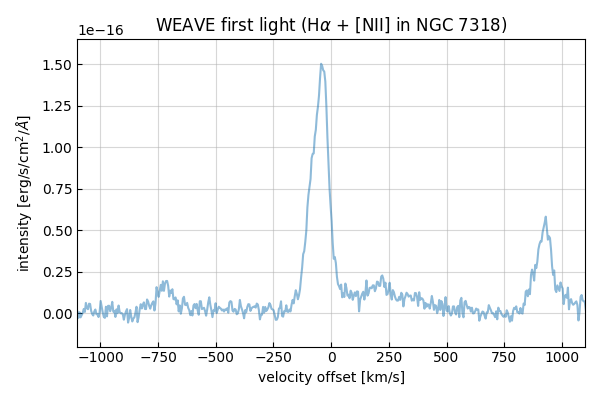

In [36]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(6, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey=False,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )

def plot_line(line, axes, row, vel_min, vel_max):
    ax = axes[row, 0]
    ax.set_ylabel(f'Continuum-subtracted {line}')

    line_centre = lines[line][0]
    blue_continuum_min = lines[line][3]*(1+redshift_b)
    blue_continuum_max = lines[line][4]*(1+redshift_b)
    red_continuum_min = lines[line][5]*(1+redshift_a)
    red_continuum_max = lines[line][6]*(1+redshift_a)
    #ax.set_xlim(blue_continuum_min, red_continuum_max)
    #ax.set_xlim(-1500, 1500)
    #ax.axvline(6630)
    #ax.axvline(5774)

    sigma = 0.
    maximum_intensity = 0.
    velocity = (wavelength/line_centre - 1) * 3e5 - 6000
    line_profile = np.nanmean(datacube[:, roi[0]:roi[1], roi[2]:roi[3]], axis=(1,2))
    line_profile -= np.nanmean(continuum[roi[0]:roi[1], roi[2]:roi[3]])
    ax.plot(velocity, line_profile, alpha=.5)

    #ax.set_ylim(1.2*minimum_intensity, maximum_intensity-.2*minimum_intensity)
    #ax.set_ylim(-sigma, maximum_intensity+sigma)
    #ax.legend()


vel_min = 5000
vel_max = 10000
plot_line('H_alpha', axes, 0, vel_min, vel_max)
#plot_line('H_beta', axes, 1, vel_min, vel_max)
#plot_line('OIII_5007', axes, 2, vel_min, vel_max)
#plot_line('SII_6717', axes, 3, vel_min, vel_max)

axes[-1, 0].set_title(r'WEAVE first light (H$\alpha$ + [NII] in NGC 7318)')
axes[-1, 0].set_ylabel(r'intensity [erg/s/cm$^2/\AA$]')
axes[-1, 0].set_ylim(-2e-17, 1.65e-16)

axes[-1, 0].set_xlabel(r'velocity offset [km/s]')
axes[-1, 0].set_xlim(-1100, 1100)

for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()